# Exhaustive algorithms
## Author: Marco Odehnal

This notebook features the implementation of the Divide and Conquer, Dynamic Programming, Branch and Bound and Branch and Bound Binary Tree (adding or removing one edge).

In [1]:
import numpy as np
import time
import itertools
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
%matplotlib inline

## Sample matrix

As these algorithms can take a great amount of time as the amount of cities increase, we decided to compare the results with a simpler 10x10 adjacency matrix.

In [2]:
X = [[25,50],
     [15,40],
     [33,65],
     [24,19],
     [7,26],
     [0,37],
     [47,5],
     [56,23],
     [39,18],
     [14,31] ]

M = np.matrix(euclidean_distances(X, X))
M[M==0] = np.inf

## 1. Divide and Conquer

In [3]:
def DivideAndConquer(adj_mat, timed = False):
    
    n = np.size(adj_mat,1)

    for i in range(0,n):
        adj_mat[i,i] = np.inf

    L = list(range(2,n+1))
    
    t1 = time.time()
    
    cost, path, duration = DnC(adj_mat,1,L,0,timed, t1)
    
    return cost, path, duration

def DnC(M,i,rem_nodes,sup_cost,timed,t1):    
    
    # If there are no more nodes to traverse, it means we reached the end of the path, so we go back to the initial vertex
    if len(rem_nodes) == 0:
        # Calculates the distance between the node and the starting point
        cost = M[i -1,0]
        return cost, [i,1], time.time()-t1
    
    else:  
        
        # Initialize minimum cost
        min_cost = np.inf
        
        # fix an element "k" and select the optimal solutions of the subproblems without k
        for k in rem_nodes:               
            
            cost = M[i -1,k -1]
            
            # YOU CAN CHANGE THE MAXIMUM TIME HERE
            if timed:
                if time.time()-t1 > 600:
                    return cost, rem_nodes, time.time() - t1                 
            
            # Recursive call to the subproblems
            sub_cost,sub_node, duration=DnC(M,k,[x for x in rem_nodes if x!= k],sup_cost + cost,timed,t1)
            
            # Storing the optimal solutions in temporary variables
            if cost + sub_cost < min_cost:
                index_opt = k
                opt_nodes = sub_node
                min_cost =  cost + sub_cost         
        
        # Return the optimal cost and the path that allowed us to find it
        return min_cost,  [i] + opt_nodes, time.time()-t1

## 2. Dynamic Programming

In [4]:
def DynamicProgramming(adj_matrix, timed = False):
    
    M = np.matrix(adj_matrix)
    
    for i in range(0,np.size(M,1)):
        M[i,i] = np.inf       
    
    n = np.size(M,1)

    L = list(range(2,n+1))

    full_set = tuple([1,tuple(range(2,len(L)+2))])
    
    # Initialization
    cost_memo_child = {}
    path_memo_child = {}    
    cost_memo_parent = {}
    path_memo_parent = {}        
    
    # 1: LEAF NODES
    S_children = list(itertools.combinations(L,1))
    #We compute the edges from the leaves to the starting point
    for k in S_children[0:len(L)]:
        cost_memo_child[k] = M[k[0]-1,0]
        path_memo_child[k] = [k[0]]    
    
    # 2: LEAF PARENT NODES
    S_parent = []
    for j in L:
        exclude = [] + L
        exclude.remove(j)
        combos = list(itertools.combinations(exclude, 1))
        for k in combos:
            s = tuple([j,k])
            S_parent += [s]
            # Update memos
            cost_memo_parent[s] = M[j-1,k[0]-1] + cost_memo_child[k]
            path_memo_parent[s] = [j] + path_memo_child[k]        

    t1 = time.time()
    
    # 3. GENERAL ALGORITHM

    for i in range(2,len(L)):
        
        cost_memo_child = cost_memo_parent
        path_memo_child = path_memo_parent
        cost_memo_parent = {}
        path_memo_parent = {}
        
#         print(cost_memo_child)
        
        for j in L:
            exclude = [] + L
            exclude.remove(j)
            combos = list(itertools.combinations(exclude, i))  
            
            for k in combos:
                
                # Initialize min cost
                min_cost = np.inf                   
                
                for l in k:

                    # We rewrite the available paths as an already solved problems
                    avail_nodes = list(k)
                    avail_nodes.remove(l)
                    s = tuple([l,tuple(avail_nodes)])   

                    # Compute the cost
                    cost = M[j-1,l-1] + cost_memo_child[s]

                    # YOU CAN CHANGE THE MAXIMUM TIME HERE
                    if timed:
                        if time.time()-t1 > 600:
                            return cost_memo_child[s], path_memo_child[s], time.time() - t1  

                    if cost < min_cost:
                        min_cost = cost
                        min_path = [j] + path_memo_child[s]                
                
                # This is the real tuple of the parent nodes subproblem
                z = tuple([j,k])
                    
                # Update memos
                cost_memo_parent[z] = min_cost
                path_memo_parent[z] = min_path

    # 4. FULL SET
    cost_memo_child = cost_memo_parent
    path_memo_child = path_memo_parent
    cost_memo_parent = {}
    path_memo_parent = {}                


    # Initialize min cost
    min_cost = np.inf                   

    k = full_set[1]
    
    for l in k:

        # We rewrite the available paths as an already solved problems
        avail_nodes = list(k)
        avail_nodes.remove(l)
        s = tuple([l,tuple(avail_nodes)])   

        # Compute the cost
        cost = M[0,l-1] + cost_memo_child[s]

        # YOU CAN CHANGE THE MAXIMUM TIME HERE
        if timed:
            if time.time()-t1 > 600:
                return cost_memo_child[s], path_memo_child[s], time.time() - t1  

        if cost < min_cost:
            min_cost = cost
            min_path = [1] + path_memo_child[s]                  
    
    path_memo_parent[full_set] = min_path + [1]
    cost_memo_parent[full_set] = min_cost
    
    # 5. RETURN
    
    return cost_memo_parent[full_set], path_memo_parent[full_set], time.time() - t1

# 3. Branch and Bound (classic approach)

In [5]:
# To run the classical Branch and Bound method, use this function.
def BranchAndBound(adj_mat, timed = False):
    
    n = np.size(adj_mat,1)

    for i in range(0,n):
        adj_mat[i,i] = np.inf
    
    rem_nodes = list(range(2,n+1))
    cost = 0
    optimal_cost = np.inf
    v = [1] 
    
    t1 = time.time()
    cost, path, opt_cost, opt_path, duration = BnBClassic(adj_mat,v,rem_nodes,cost,optimal_cost, [], timed, t1)
        
    return opt_cost, opt_path, duration
    
        
def BnBClassic(A,v,rem_nodes, cost, optimal_cost, opt_path, timed, t1):
    
    # YOU CAN CHANGE THE MAXIMUM TIME HERE
    if timed:
        if time.time()-t1 > 6:
            return cost, v, optimal_cost, opt_path, time.time() - t1
    
    # End of the path
    if len(rem_nodes)==1:
        cost += A[v[-1]-1, rem_nodes[0]-1] + A[rem_nodes[0]-1,0]
        v += rem_nodes + [1]

        if cost < optimal_cost:
            return cost, v, cost, v, time.time() - t1
        else:
            return cost, v, optimal_cost, opt_path, time.time() - t1
    
    else:
        
        k = len(v)
        n = np.size(A,0)+1

        cost_branches = []
        path_branches = []
        f = []
        
        # Calculating the costs, the f and the paths
        for i in rem_nodes:
            cost_branches.append(cost + A[v[-1]-1,i-1])
            path_branches.append(v+[i])
            # In g we select the minimum distance we can be able to travel
            g = np.min(A[:,[x-1 for x in rem_nodes + [1] if x!= i]])
            if g == np.inf:
                continue
            f.append(cost_branches[-1] + (n-k)*
                     g)
        
        if len(f) == 0:
            return cost, v, optimal_cost, opt_path, time.time() - t1
        
        # Sorting the arrays
        order = np.argsort(f)
        cost_branches = [cost_branches[i] for i in order]
        path_branches = [path_branches[i] for i in order]
        f = [f[i] for i in order] 


        # We explore recursively the branches and check if an optimal solution can be found
        for i in range(len(f)):
            
            # We discard all of the branches that cannot decrease the cost function
            # As all of the branches are sorted by cost, the following branches after
            # a discarded one will also be discarded
            if f[i] >= optimal_cost:
                break
            else:
                rem_nodes_sub = [x for x in rem_nodes if x not in path_branches[i]]
                cost, v, optimal_cost, opt_path, duration = BnBClassic(A,path_branches[i],rem_nodes_sub, cost_branches[i], optimal_cost, opt_path, timed, t1)
            
        return cost, v, optimal_cost, opt_path, time.time()-t1

# 4. Branch and Bound (binary tree approach)

In [6]:
# HELPER functions used in the following algorithm

# This function calculates the normaliced matrix with at least one zero in each row and column.
# It also computes the cost of reduction.
def mat_redux(M, cost):
    
    # Used to reshape the minimum value arrays into matrices
    n = np.size(M,1)    
    
    # Reduction by rows
    m1 = M.min(axis=1)
    # to avoid inf-inf math error
    m1[m1 == np.inf] = 0
    Mrow = M - m1.reshape(n,1)
    
    # Reduction by columns
    m2 = Mrow.min(axis=0)
    m2[m2 == np.inf] = 0
    Mcol = Mrow - np.matrix(m2).reshape(1,n)
    
    # Lower bound calculation
    f = m1.sum() + m2.sum()
    
    return cost + f, Mcol

# This function selects the zero corresponding to the edge with the greatest weight
def select_edges(A, n):

    # We wish to know where are the pivots
    zeros_irow, zeros_icol = np.where(A==0)

    # Variables initialization
    max_edge_cost = 0
    opt_edge = (0,0)

    #  We traverse every zero such that it has the highest cost
    for k in range(len(zeros_irow)):
        
        i = zeros_irow[k]
        j = zeros_icol[k]
        x = [x for x in range(0,n) if x != i]
        y = [x for x in range(0,n) if x != j]

        edge_cost = np.min(A[i,y]) + np.min(A[x,j])   
        
        if edge_cost > max_edge_cost:
            
            max_edge_cost = edge_cost
            opt_edge = (i,j)

    return opt_edge

# This function created the children Left and Right subtree (with and without the edge)
def children_subtrees(M, edge, f):
    
    # Left and Right matrices
    L = np.copy(M)
    R = np.copy(M)

    # For the left child we add infinity to the column and row corresponding to the chosen edge
    try:
        L[edge[0],:] = np.inf
        L[:,edge[1]] = np.inf
        L[edge[1],edge[0]] = np.inf
    except:
        print(edge)
    # After this the matrix should be reduced
    f_L, L = mat_redux(L,f)

    # For the right child we just add infinity to the location of the node, so that it's excluded
    R[edge[0], edge[1]] = np.inf
    f_R, R = mat_redux(R,f)

    return f_L, L, f_R, R

# Function used to reconstruct the path from the given edges 
# (the edge list is assumed to be same size of the number of cities)
def create_path_from_edges(EdgeList):
    
    E = EdgeList + []
    
    n = len(E)
    path = [1]
    possible = True

    while True:

        continue_chain = 0

        for i in E:
            if i[0] == path[0]-1:
                path = [i[1]+1] + path
                continue_chain = 1
                break
                
        if len(E)==0:
            return []

        E.remove(i)

        if continue_chain == 0:
            return []
        if len(path) == n:
            return [1]+path[:-1]

In [7]:
def BranchAndBoundBinaryTree(adj_mat, timed = False):
    
    for i in range(0,np.size(adj_mat,1)):
        adj_mat[i,i] = np.inf    
    
    t1 = time.time()
    cost, path, duration = BnBBinaryTree(adj_mat, timed, t1)
        
    return cost, path, duration 

# The algorithm
def BnBBinaryTree(M,timed, t1):
    
    # Matrix reduction step
    f,MR = mat_redux(M,0)
    
    n = np.size(M,1)

    cost, edges_col, opt_edge_col, duration = BnBBinaryTreeRecursive(MR,[],f,np.inf, [], n, timed, t1)
    
    return cost, create_path_from_edges(opt_edge_col)+[1], duration  

# This is the recursive algorithm that is called after pre-processing the matrix    
def BnBBinaryTreeRecursive(M, edges_collection, cost, opt_cost, opt_edge_col, n, timed, t1):

    # YOU CAN CHANGE THE MAXIMUM TIME HERE
    if timed:
        if time.time()-t1 > 600:
            return opt_cost, edges_collection, opt_edge_col, time.time() - t1        
    # If the optimum cost is less than the actual cost we are not supposed to do anything
    if opt_cost <= cost:
        return opt_cost, edges_collection, opt_edge_col, time.time() - t1  
    
    # We know that we cannot find a solution if there are less nodes than cities to visit
    if n-len(edges_collection) > np.sum(M.min(axis=1) == 0):
        return opt_cost, edges_collection, opt_edge_col, time.time() - t1  
    
    # If the search is complete, a solution has been found
    elif n-len(edges_collection) == np.sum(M.min(axis=1) == 0) == 0:
        if cost < opt_cost:
            if len(create_path_from_edges(edges_collection)) != 0:
                return cost, edges_collection, edges_collection, time.time() - t1  
            else:
                return opt_cost, edges_collection, opt_edge_col, time.time() - t1  
        else:
            return opt_cost, edges_collection, opt_edge_col, time.time() - t1  
    
    # Edge selection
    edge = select_edges(M, n)
    
    if edge == (0,0):
        return opt_cost, edges_collection, opt_edge_col, time.time() - t1  
    
    # Children trees creation
    f_L, L, f_R, R = children_subtrees(M, edge, cost, )
    
    # We search the trees
    opt_cost, edges_col, opt_edge_col, duration = BnBBinaryTreeRecursive(L, edges_collection + [edge], f_L, opt_cost, opt_edge_col, n, timed, t1)
    if opt_cost > f_R:
        opt_cost, edges_col, opt_edge_col, duration = BnBBinaryTreeRecursive(R, edges_collection, f_R, opt_cost, opt_edge_col, n, timed, t1)
        
    return opt_cost, edges_col, opt_edge_col, time.time() - t1  

## 5. Evaluation

In [8]:
print('1) Divide and Conquer:')
c1,p1,t1 = DivideAndConquer(M, timed = False)
print('Optimum cost: %s, \nOptimum cycle: %s, \nTime: %s seconds.\n'% (c1,p1,t1))
print('2) Dynamic Programming:')
c2,p2,t2 = DynamicProgramming(M, timed = False)
print('Optimum cost: %s, \nOptimum cycle: %s, \nTime: %s seconds.\n'% (c2,p2,t2))
print('3) Branch and Bound Classic:')
c3,p3,t3 = BranchAndBound(M, timed = False)
print('Optimum cost: %s, \nOptimum cycle: %s, \nTime: %s seconds.\n'% (c3,p3,t3))
print('4) Branch and Bound Binary Tree:')
c4,p4,t4 = BranchAndBoundBinaryTree(M, timed = False)
print('Optimum cost: %s, \nOptimum cycle: %s, \nTime: %s seconds.\n'% (c4,p4,t4))

1) Divide and Conquer:
Optimum cost: 182.007948867, 
Optimum cycle: [1, 2, 6, 5, 10, 4, 9, 7, 8, 3, 1], 
Time: 2.94808292388916 seconds.

2) Dynamic Programming:
Optimum cost: 182.007948867, 
Optimum cycle: [1, 2, 6, 5, 10, 4, 9, 7, 8, 3, 1], 
Time: 0.025015830993652344 seconds.

3) Branch and Bound Classic:
Optimum cost: 182.007948867, 
Optimum cycle: [1, 2, 6, 5, 10, 4, 9, 7, 8, 3, 1], 
Time: 0.637458086013794 seconds.

4) Branch and Bound Binary Tree:
Optimum cost: 182.007948867, 
Optimum cycle: [1, 2, 6, 5, 10, 4, 9, 7, 8, 3, 1], 
Time: 3.1352157592773438 seconds.



## 6. Plotting the optimal cycle

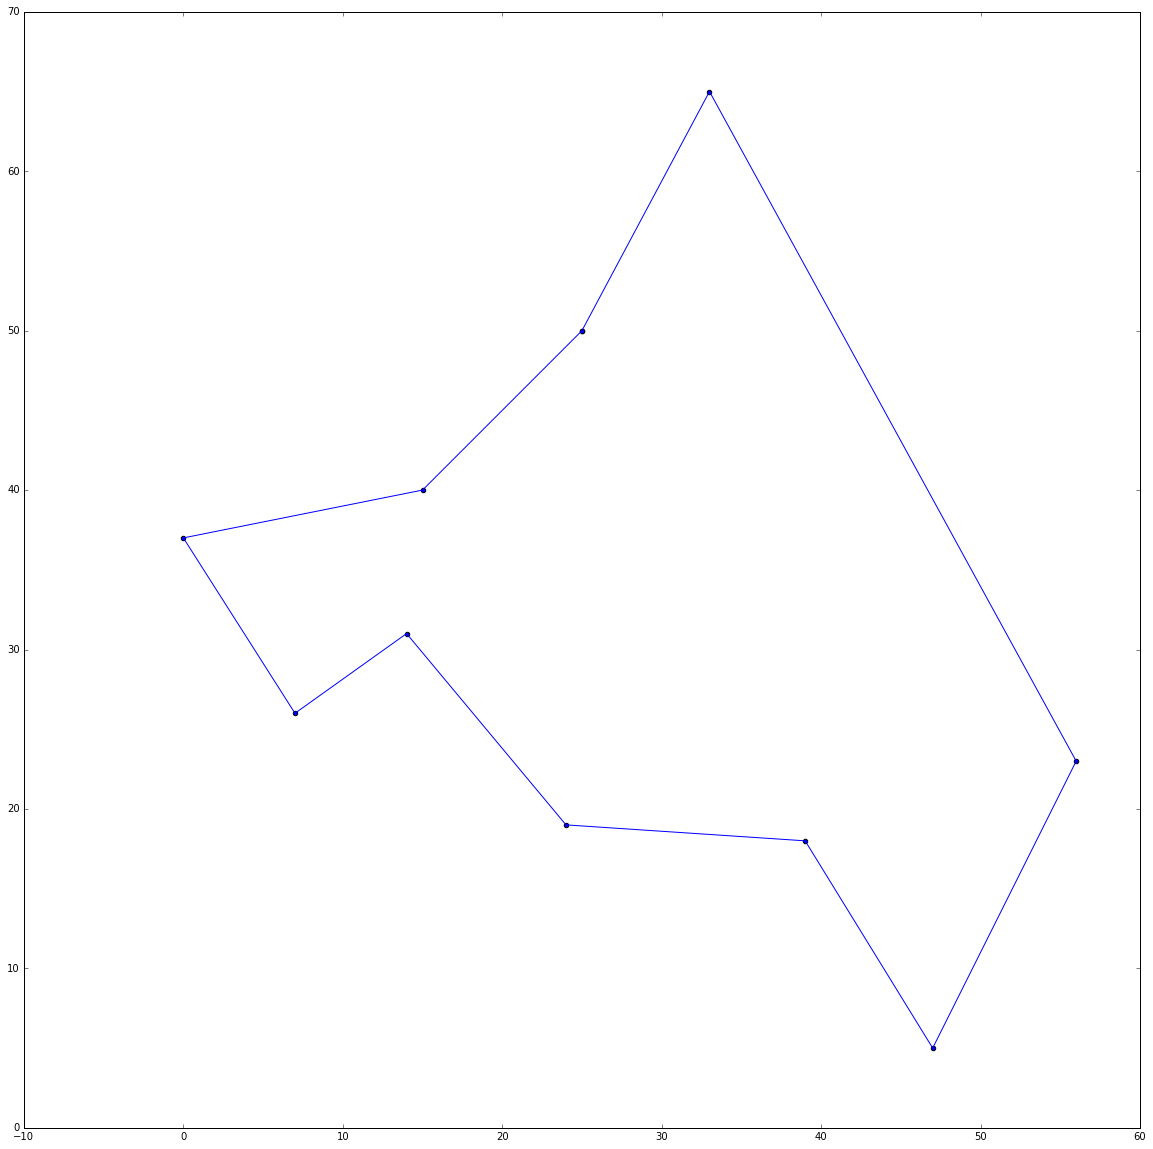

Route: [0 1 5 4 9 3 8 6 7 2 0]

Distance:  182.007948867


In [9]:
opt_route = [x-1 for x in p2][:-1]
data_json = X
total_distance = c2

plt.figure(figsize=(20,20))

opt_route = list(opt_route)
opt_route.append(opt_route[0])
opt_route = np.array(opt_route)

data_json = list(data_json)
data_json.append(data_json[0])
data_json = np.array(data_json)

# Reorder the cities matrix by route order in a new matrix for plotting.
new_cities_order = np.concatenate((np.array([data_json[opt_route[i]] for i in range(len(opt_route))]),np.array([data_json[0]])))
# Plot the cities.
plt.scatter(data_json[:,0],data_json[:,1])
# Plot the path.
plt.plot(new_cities_order[:,0],new_cities_order[:,1])
plt.show()
# Print the route as row numbers and the total distance travelled by the path.
print("Route: " + str(opt_route) + "\n\nDistance: ",total_distance)